<div>
    <h1><center>
        <img src="https://its-live-data.s3.amazonaws.com/documentation/ITS_LIVE_logo.png" width="500"/>
        </center></h1>
    <h1><center>
        glacier velocity point data access<br>
        using ITS_LIVE velocity basemap<br>
        </center></h1>
</div>

---

Author: Mark Fahnestock, Geophysical Institute, University of Alaska Fairbanks
Date: October 28, 202

--- 

# Intro
This notebook allows you to select a locaiton from high-resolution imagery, fetch all available ITS_LIVE glacier velocities for that location, and plot the results. These steps can be repeated to plot multiple locations on a single figure. 

Underling data is stored on AWS S3 as Zarr datacubes and is accessed without an intermediate server. Glacier velocities are derived from all available Landsat 8, Sentinel-1A/B, Sentinel-2A/B imagery.

Please refer to the <a href="https://its-live.jpl.nasa.gov/">project website</a> for further product infomation and for appraopriate data citation.

 

# Setting up a local environment

at the terminal:
>conda create --name pg5 -c conda-forge h5netcdf fiona imagemagick shapely jupyter netcdf4 psutil h5py zarr matplotlib gdal  xarray  boto3 pyproj ipympl s3fs

activate newly created environment:
> conda activate pg5

start jupyter in browser
> jupyter notebook


In [8]:
#first bunch of imports to read and plot timeseries from datacubes in S3 using xarry->zarr
import xarray as xr
import numpy as np
# import s3fs as s3
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap # to set up custom ITS_LIVE colormap
import time

#second bunch to identify datacubes from geojson catalog and picked point
import json
import shapely
import fiona
import pyproj
from shapely import geometry

# gdal for geospatial image io
# recent conda installs have gdal in osgeo - just import gdal if this fails (could catch this if a problem)
try:
    import gdal, osr
except:
    from osgeo import gdal, osr

# use widget interface in this notebook for interactive pyplot plots
# %matplotlib notebook
%matplotlib widget

import ipywidgets as wdg
# use ipywidgets for output text to track progress of download call
# output widget is created here, but not displayed until the interactive plot code cell so it stays with plots
outwdgt = wdg.Output(layout={'border': '1px solid blue'})

# notebook is set up to use regional speed mosaics as basemaps - chose your region here:
region = 'SRA'
region_dict = {
    # HMA is missing - mosaic srs does not return needed EPSG code here, needs to be updated or hard-wired to work
#     "speed_mosaic_URL_base":'/vsicurl/http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_mosaic/landsat/v00.0/static/cog/',
#     "speed_mosaic_URL_base":'/vsicurl/https://its-live-data.s3.amazonaws.com/velocity_mosaic/landsat/v00.0/static/cog/',
    "speed_mosaic_URL_base":'/vsis3/its-live-data/velocity_mosaic/landsat/v00.0/static/cog/',
    "ANT":{"pltvmax":4000, "speed_mosaic_tif":'ANT_G0240_0000_v_10_percent_overview.tif'},
    "GRE":{"pltvmax":4000, "speed_mosaic_tif":'GRE_G0120_0000_v_10_percent_overview.tif'},
    "ALA":{"pltvmax":625, "speed_mosaic_tif":'ALA_G0120_0000_v_10_percent_overview.tif'},
    "SRA":{"pltvmax":625, "speed_mosaic_tif":'SRA_G0120_0000_v_25_percent_overview.tif'},
    "CAN":{"pltvmax":625, "speed_mosaic_tif":'CAN_G0120_0000_v_10_percent_overview.tif'},
    "PAT":{"pltvmax":625, "speed_mosaic_tif":'PAT_G0120_0000_v_25_percent_overview.tif'},
}

speed_mosaic_URL = region_dict["speed_mosaic_URL_base"] + region_dict[region]['speed_mosaic_tif']
# pltvmax is the top end of the color scale used in the map figure
speed_mosaic_pltvmax = region_dict[region]['pltvmax']

# open image with GDAL and get extents, projection
# first set gdal (and via ogr -> fiona(s3://...)) to access public bucket anonomously
gdal.SetConfigOption('AWS_NO_SIGN_REQUEST', 'YES')
#inmap_gd is gdal geospatial image object
inmap_gd=gdal.Open(speed_mosaic_URL)

# load velocity mosaic as numpy array to use for basemap
vmap=inmap_gd.ReadAsArray()

# Nan the nodata pixels so they display as empty
inmap_nodata_value = inmap_gd.GetRasterBand(1).GetNoDataValue()
vmap[vmap==inmap_nodata_value] = np.nan

#get extents of basemap
gt = inmap_gd.GetGeoTransform()
inmap_min_x = gt[0]
inmap_max_x = gt[0] + inmap_gd.RasterXSize * gt[1]
inmap_min_y = gt[3] + gt[5]*inmap_gd.RasterYSize
inmap_max_y = gt[3]

# get pixel size in meters and number of pixels
inmap_pix_x_m = gt[1]
inmap_pix_y_m = gt[5]
inmap_num_pix_x = inmap_gd.RasterXSize
inmap_num_pix_y = inmap_gd.RasterYSize

# get the basemap projection, find EPSG code to use for reprojecting chosen point locations
srs = osr.SpatialReference()
srs.ImportFromWkt(inmap_gd.GetProjection())
map_epsg = srs.GetAuthorityCode('PROJCS')

print(f'working with basemap from region {region} - basemap projection EPSG: {map_epsg}')


working with basemap from region SRA - basemap projection EPSG: 3413


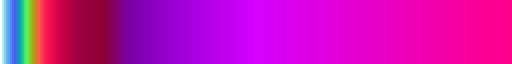

In [9]:
# make ITS_LIVE default_vel and low_vel color maps
# default (- string version below exported from QGIS, 0-4000 m/yr in QGIS files, normalized below to 0-1 for matplotlib)
intext_ITSLIVE_QGIS_default = \
"""0,255,255,255,255,0
10,166,238,255,255,10
20,166,238,255,255,20
40,97,195,219,255,40
60,84,169,254,255,60
80,84,130,254,255,80
100,84,85,254,255,100
120,50,119,220,255,120
140,16,153,186,255,140
160,16,186,153,255,160
180,50,220,119,255,180
200,84,254,85,255,200
220,118,221,51,255,220
240,153,186,16,255,240
260,187,152,17,255,260
280,221,118,51,255,280
300,255,85,85,255,300
350,255,25,85,255,350
450,213,1,72,255,450
600,158,1,66,255,600
800,140,0,51,255,800
1000,122,0,166,255,1000
1200,140,0,191,255,1200
1400,159,0,217,255,1400
2000,213,0,255,255,2000
4000,255,0,138,255,4000
"""


def make_cmap(name,intext):
    lines=intext.split()
    # grab max speed value to normalize from 0-1
    maxspeedval = float(lines[-1].split(',')[0])

    qgis_tuples = []
    for line in lines:
        x = float(line.split(',')[0])/maxspeedval
        r,g,b,a = [float(x)/255.0 for x in line.split(',')[1:-1]]
        qgis_tuples.append((x,r,g,b,a))

    cdict = { 'red':[], 'green':[], 'blue':[], 'alpha':[] }

    for x,r,g,b,a in qgis_tuples:
            cdict['red'].append((x,r,r))
            cdict['green'].append((x,g,g))
            cdict['blue'].append((x,b,b))
            cdict['alpha'].append((x,a,a))

    vel_colormap = LinearSegmentedColormap(name,cdict)
    vel_colormap.set_bad((0.25,0.25,0.25,0.25))
    return(vel_colormap)


itslive_default_cmap = make_cmap('itslive_default',intext_ITSLIVE_QGIS_default)

# result created above can be called with cmap=itslive_default_cmap in plt.imshow, etc.

# to display colormap in notebook uncomment next line
itslive_default_cmap


In [10]:
class timeseriesException(Exception):
    pass

def get_timeseries(inpointxy,point_epsg_str, open_tile):
    
    start = time.time()
    
    if point_epsg_str != '4326':
        # point not in lon,lat, set up tranformation and convert it to lon,lat (epsg:4326)
        inPROJtoLL = pyproj.Transformer.from_proj(f'epsg:{point_epsg_str}','epsg:4326',always_xy=True)
        pointll = inPROJtoLL.transform(*inpointxy)
    else:
        # point already lon,lat
        pointll = inpointxy
    
    # create Shapely point object for inclusion test
    point = geometry.Point(*pointll) # point.coords.xy
    
    # find datacube outline that contains this point in geojson index file
    cubef = None
    
#     s3/its-live-data.jpl.nasa.gov/datacubes/v01/datacubes_100km_v01.json
        
    with fiona.open('s3://its-live-data/test_datacubes/v02/datacubes_catalog.json','r') as infio:
#     with fiona.open('s3://its-live-data.jpl.nasa.gov/datacubes/v01/datacubes_100km_v01.json','r') as infio:
        for f in infio:
            polygeom = geometry.shape(f['geometry'])
            if polygeom.contains(point):
                cubef = f
                
    if cubef:
        print(f'found datacube - elapsed time: {(time.time()-start):10.2f}',flush=True)
        
        if point_epsg_str == cubef['properties']['data_epsg']:
            point_tilexy = inpointxy
        else:
            inPROJtoTilePROJ = pyproj.Transformer.from_proj(f'epsg:{point_epsg_str}',cubef['properties']['data_epsg'],always_xy=True)
            point_tilexy = inPROJtoTilePROJ.transform(*inpointxy)

        # now test if point is in xy box for cube (should be most of time, could fail because of boundary curvature - 4326 box defined by lon,lat corners, but point chosen in basemap projection)                        
        point_tilexy_shapely = geometry.Point(*point_tilexy)
        polygeomxy = geometry.shape(cubef['properties']['geometry_epsg'])
        if not polygeomxy.contains(point_tilexy_shapely):
            raise timeseriesException(f"point is in lat,lon box but not {cubef['properties']['data_epsg']} box!!!!!!!")
            
        # for zarr store modify URL for use in boto open - change http: to s3: and lose s3.amazonaws.com
        incubeurl = cubef['properties']['zarr_url'].replace('http:','s3:').replace('.s3.amazonaws.com','')
        ins3xr = xr.open_dataset(
            incubeurl,
            engine="zarr",
            storage_options={'anon':True},
        )

        print(f'xarray open - elapsed time: {(time.time()-start):10.2f}',flush=True)

        # end for zarr store

        return (ins3xr,point_tilexy)
    
    else:
        raise timeseriesException(f'no datacube found for point {pointll}')
    


In [11]:

# decorator captures function output in widget
@outwdgt.capture(clear_output=True,wait=True)
def plotfig(pointxy,nax,map_epsg):
    global ins3xr
    global point_v # hopefully these are available in the global context after a call...
    # pointxy is [x,y] coordinate in mapfig projection (map_epsg below), nax is plot axis for time series plot
    start = time.time()
    print(f'finding timeseries for point x={pointxy[0]:10.2f} y={pointxy[1]:10.2f} color {colors[color_index]} symbol {symbols[color_index]}',flush=True)

    ins3xr,point_tilexy = get_timeseries(pointxy,map_epsg) # returns xarray dataset object (used for time axis in plot) and already loaded v time series
    point_v = ins3xr["v"].sel(x=point_tilexy[0],y=point_tilexy[1],method="nearest")

    point_v.load()

    print(f'time series loaded {len(point_v)} points - elapsed time: {(time.time()-start):10.2f}',flush=True)
        
    dt = ins3xr['date_dt'].values 
    dt = dt.astype(float)*1.15741e-14;
    max_dt = 90; # set the maximum image-pair time seperation (dt) that will be plotted
    
    nax.plot(ins3xr.mid_date[dt < max_dt],point_v[dt < max_dt], colors[color_index] + symbols[color_index])
    total_time = time.time()-start
    print(f'elapsed time: {total_time:10.2f} - {len(point_v)/total_time:6.1f} points per second',flush=True)


In [16]:
ins3xr

<xarray.Dataset>
Dimensions:                    (mid_date: 16048, y: 834, x: 833)
Coordinates:
  * mid_date                   (mid_date) datetime64[ns] 2018-04-20T00:47:00....
  * x                          (x) float64 1e+06 1e+06 1e+06 ... 1.1e+06 1.1e+06
  * y                          (y) float64 -3.001e+05 -3.002e+05 ... -4e+05
Data variables: (12/72)
    acquisition_date_img1      (mid_date) datetime64[ns] ...
    acquisition_date_img2      (mid_date) datetime64[ns] ...
    autoRIFT_software_version  (mid_date) <U5 ...
    chip_size_height           (mid_date, y, x) float32 ...
    chip_size_width            (mid_date, y, x) float32 ...
    date_center                (mid_date) datetime64[ns] ...
    ...                         ...
    vyp_error_mask             (mid_date) float64 ...
    vyp_error_modeled          (mid_date) float64 ...
    vyp_error_slow             (mid_date) float64 ...
    vyp_stable_shift           (mid_date) float64 ...
    vyp_stable_shift_mask      (mid_date) float64 ...
    vyp_stable_shift_slow      (mid_date) float64 ...
Attributes: (12/16)
    GDAL_AREA_OR_POINT:             Area
    author:                         ITS_LIVE, a NASA MEaSUREs project (its-li...
    autoRIFT_parameter_file:        http://its-live-data.jpl.nasa.gov.s3.amaz...
    datacube_software_version:      1.0
    date_created:                   27-10-2021 03:10:55
    date_updated:                   27-10-2021 03:10:55
    ...                             ...
    skipped_duplicate_middle_date:  []
    skipped_empty_data:             ["http://its-live-data.jpl.nasa.gov.s3.am...
    skipped_wrong_projection:       {}
    time_standard_img1:             UTC
    time_standard_img2:             UTC
    title:                          ITS_LIVE datacube of image_pair velocities

Output(layout=Layout(border='1px solid blue'))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
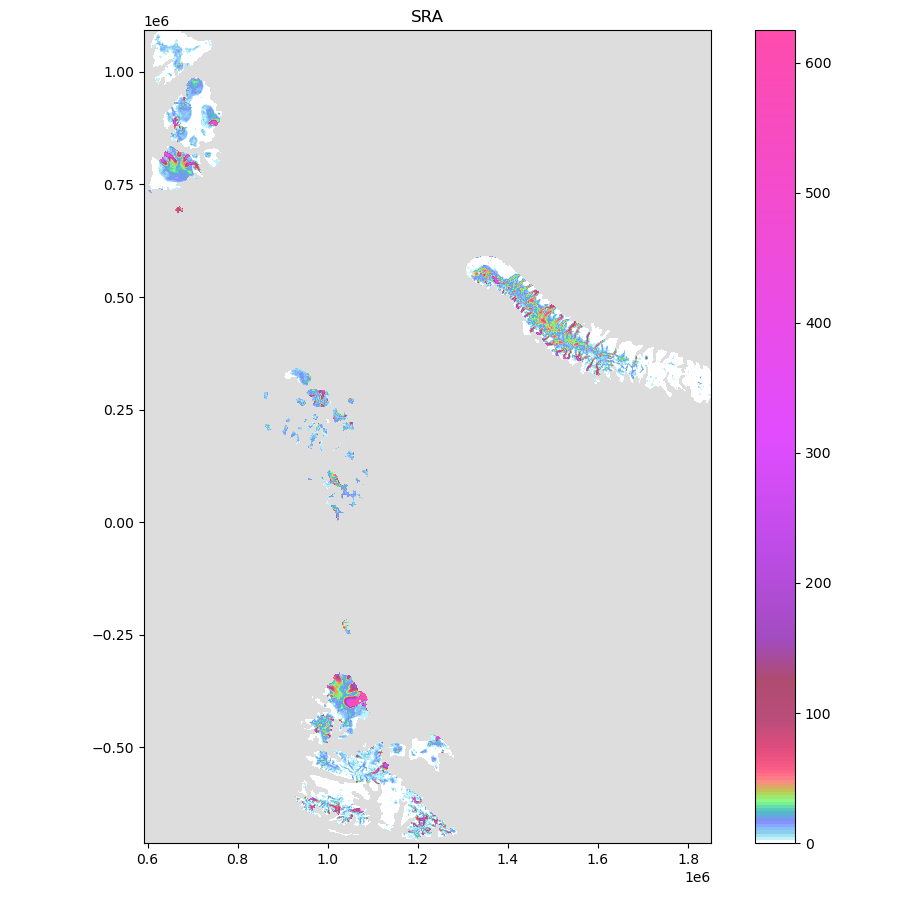

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
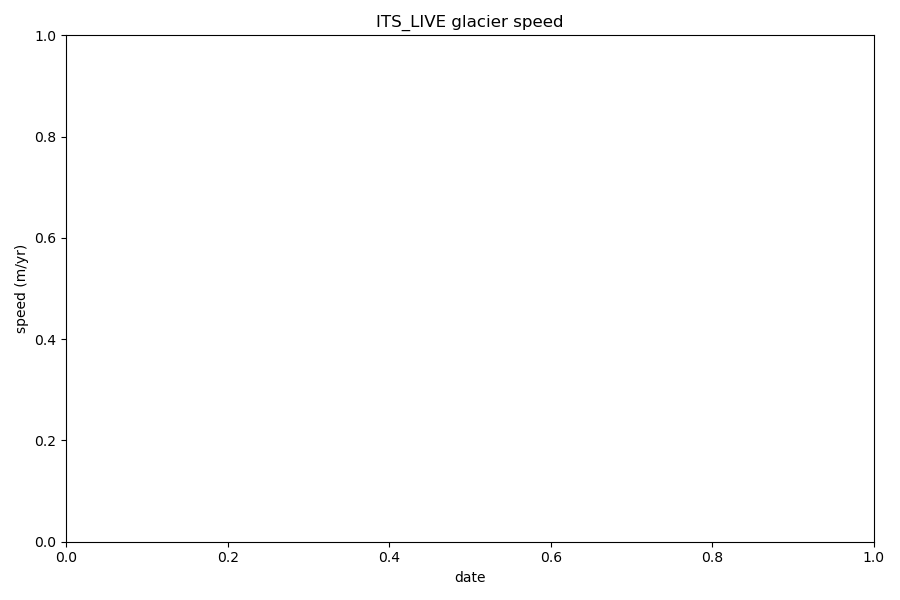

In [12]:

# from first answer here (how to avoid recording clicks from fig zoom - only a click if no drag) 
# https://stackoverflow.com/questions/48446351/distinguish-button-press-event-from-drag-and-zoom-clicks-in-matplotlib
class Click():
    def __init__(self, ax, func, button=1):
        self.ax=ax
        self.func=func
        self.button=button
        self.press=False
        self.move = False
        self.c1=self.ax.figure.canvas.mpl_connect('button_press_event', self.onpress)
        self.c2=self.ax.figure.canvas.mpl_connect('button_release_event', self.onrelease)
        self.c3=self.ax.figure.canvas.mpl_connect('motion_notify_event', self.onmove)

    def onclick(self,event):
        if event.inaxes == self.ax:
            if event.button == self.button:
                self.func(event, self.ax)
    def onpress(self,event):
        self.press=True
    def onmove(self,event):
        if self.press:
            self.move=True
    def onrelease(self,event):
        if self.press and not self.move:
            self.onclick(event)
        self.press=False; self.move=False

        

pointxy = [np.nan, np.nan] # define here just to see if it is really set in the callback

# set up color/symbol sequence for plots - will fail after 18 points...
colors = 3*"bgrmky"
symbols =  "++++++xxxxxxvvvvvv"
color_index = -1


# Define a callback function that will update the map plot and call plotfig to read point data and plot it
def onclick(event, ax):
    global pointxy    # ensures the pointxy from the scope above is assigned the value when changed
    global color_index
    ptx = event.xdata
    pty = event.ydata

    color_index += 1
    
    # keep map axis from rescaling on point plot
    ax.autoscale(False)
    # plot marker on map at clicked location
    ax.plot(ptx,pty, colors[color_index] + symbols[color_index], mew=4, ms=10)
    
    pointxy = [ptx,pty]
    
    # get time series at point and add it to the time series plot
    plotfig(pointxy,plotax,map_epsg)


    
mapfig,mapax = plt.subplots(1,1,figsize=(9,9))

colormappable = mapax.imshow(vmap,vmin=0,vmax=speed_mosaic_pltvmax,cmap=itslive_default_cmap,extent=[inmap_min_x,inmap_max_x,inmap_min_y,inmap_max_y],alpha=0.7)
mapfig.tight_layout()
mapax.set_title(region)
mapfig.colorbar(colormappable)

# from IPython.display import display
display(outwdgt)

pltfig,plotax = plt.subplots(1,1,figsize=(9,6))
plotax.set_xlabel('date')
plotax.set_ylabel('speed (m/yr)')
plotax.set_title('ITS_LIVE glacier speed')

pltfig.tight_layout()

click = Click(mapax, onclick, button=1)




Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
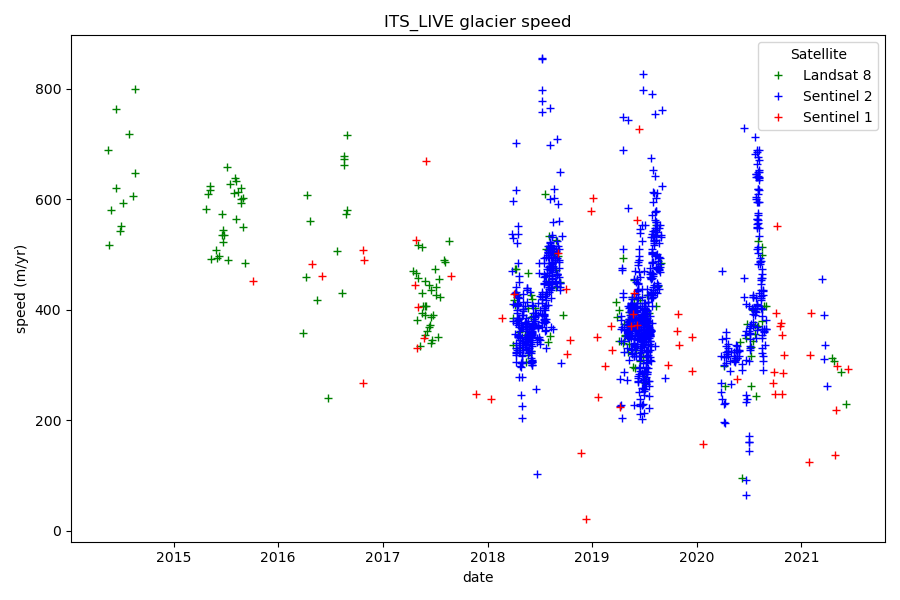

In [15]:
sat = np.array([x[0] for x in ins3xr['satellite_img1'].values])
dt = ins3xr['date_dt'].values 
dt = dt.astype(float)*1.15741e-14;
max_dt = 90;
sats = np.unique(sat)
sat_plotsym_dict = {
                    '1':'r+',
                    '2':'b+',
                    '8':'g+',
}

sat_label_dict = {
                    '1':'Sentinel 1',
                    '2':'Sentinel 2',
                    '8':'Landsat 8',
}

pltfig2,plotax2 = plt.subplots(1,1,figsize=(9,6))
plotax2.set_xlabel('date')
plotax2.set_ylabel('speed (m/yr)')
plotax2.set_title('ITS_LIVE glacier speed')

for satellite in sats[::-1]:
    plotax2.plot(ins3xr.mid_date.values[(sat==satellite) & (dt < max_dt)],point_v.values[(sat==satellite) & (dt < max_dt)], sat_plotsym_dict[satellite], label=sat_label_dict[satellite])

plotax2.legend(title='Satellite')
pltfig2.tight_layout()

